In [255]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#modelos y métricas
# import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree
# preprocesamiento
from sklearn.preprocessing import MinMaxScaler

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Creamos una copia del dataset para comenzar a trabajar.

In [256]:
ds_hotel=pd.read_csv('./hotels_train_filtrado2.csv')
ds_trabajo = ds_hotel.copy()

Nos fijamos si tenemos registos enteros duplicados en el dataset.

In [257]:
ds_trabajo.duplicated().sum()

0

Tenemos 17059 duplicados. Como son registros totalmente duplicados, es decir, tienen todas sus columnas idénticas, vamos a eliminarlos ya que no proporcionan información adicional y podrían sesgar nuestro análisis

In [258]:
ds_trabajo = ds_trabajo.drop_duplicates()

In [259]:
ds_trabajo.shape

(61913, 24)

Para la detección de outliers en nuestro dataset, vamos a comenzar realizando un análisis univariado para cada una de sus columnas y decidiremos qué tratamiento darles a aquellos valores atípicos que encontremos.

In [260]:
ds_trabajo.columns.to_list()

['hotel',
 'lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'deposit_type',
 'customer_type',
 'adr',
 'total_of_special_requests',
 'reservation_status_date',
 'id',
 'is_canceled',
 'arrival_date',
 'region',
 'agent_specified',
 'total_guests',
 'more_than_zero_days_in_waiting_list',
 'season',
 'room_type_match']

En la notebook_1, analizamos las distribuciones de todas estas columnas y ya observamos que algunas de ellas no presentaban valores atípicos:
- `hotel` no presenta valores atípicos. Analizamos anteriormente su distribución mediante un gráfico de torta y observamos que sus dos categorías presentan porcentajes considerables (siendo estos 68% y 32%)
- `season` no presenta valores atípicos. Vimos en un barplot anteriormente que todas las categorías tienen frecuencias considerables
- `is_repeated_guest`, `is_canceled`, `agent_specified`, `more_than_zero_days_in_waiting_list`, `room_type_match` son booleanas y no presentan valores atípicos

En el caso de `lead_time`, habíamos analizado su distribución mediante un boxplot y presentaba outliers.

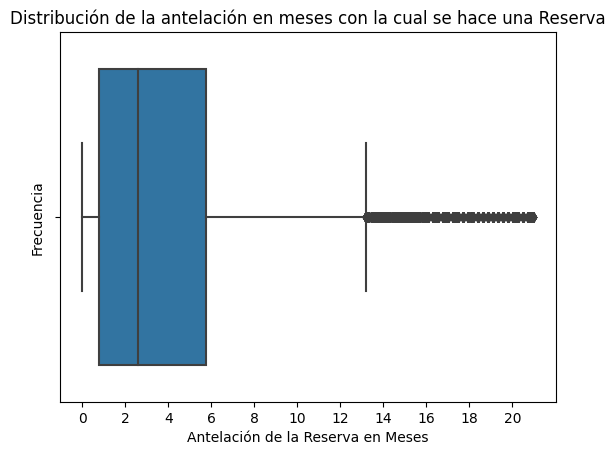

In [261]:
sns.boxplot(x=ds_trabajo["lead_time"])
plt.xticks(range(0, 22, 2))
plt.xlabel('Antelación de la Reserva en Meses')
plt.ylabel('Frecuencia')
plt.title('Distribución de la antelación en meses con la cual se hace una Reserva')
plt.show()

In [262]:
#Cuartiles
Q1_lead_time=np.quantile(ds_trabajo.lead_time,0.25)
Q3_lead_time=np.quantile(ds_trabajo.lead_time,0.75)

#Rango intercuartil
IQR_lead_time=Q3_lead_time-Q1_lead_time

#Limite inferior Outliers
out_inf=Q1_lead_time-1.5*IQR_lead_time
out_sup=Q3_lead_time+1.5*IQR_lead_time
print(out_inf)
print(out_sup)

-6.683333333333334
13.183333333333334


Vamos a ver cuántos valores están 1.5 veces por debajo y por encima del IQR para `lead_time`.

In [263]:
outliers_inf = ds_trabajo[ds_trabajo['lead_time'] < out_inf]
print("Outliers inferiores:",outliers_inf["lead_time"].count())
outliers_sup = ds_trabajo[ds_trabajo['lead_time'] > out_sup]
print("Outliers superiores:",outliers_sup["lead_time"].count())

Outliers inferiores: 0
Outliers superiores: 1369


No tenemos negativos en esta columna al tratarse de una cantidad de meses, (ya habíamos hecho este análisis), por lo tanto no tendremos outliers por este lado. En cuanto a los outliers superiores, es una cantidad reducida de registros. Sin embargo, creemos que el tiempo de antelación con el cual se realiza una reserva puede ser un factor importante para determinar una cancelación. Además, en la notebook_1 habíamos hecho un scatter plot de `lead_time` junto con `is_canceled` y notamos que a partir de los 10 meses se cancelaba con mayor frecuencia. Por lo tanto vamos a conservar estos outliers.

En cuanto a `stays_in_weekend_nights` vemos en un boxplot que tenemos algunos valores atípicos.

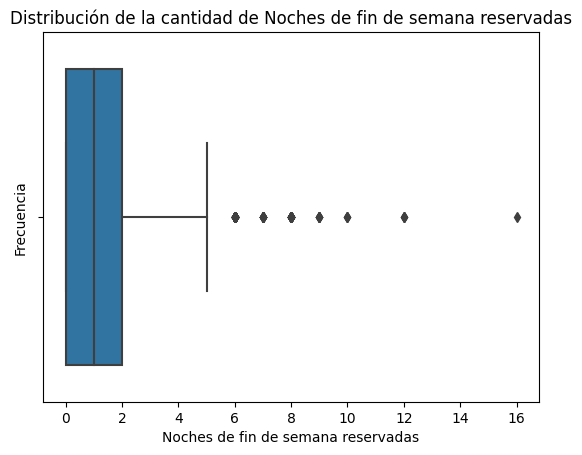

In [264]:
sns.boxplot(x=ds_trabajo["stays_in_weekend_nights"])
plt.xlabel('Noches de fin de semana reservadas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de Noches de fin de semana reservadas')
plt.show()

In [265]:
#Cuartiles
Q1_stays_in_weekend_nights=np.quantile(ds_trabajo.stays_in_weekend_nights,0.25)
Q3_stays_in_weekend_nights=np.quantile(ds_trabajo.stays_in_weekend_nights,0.75)

#Rango intercuartil
IQR_stays_in_weekend_nights=Q3_stays_in_weekend_nights-Q1_stays_in_weekend_nights

#Limite inferior Outliers
out_inf=Q1_stays_in_weekend_nights-1.5*IQR_stays_in_weekend_nights
out_sup=Q3_stays_in_weekend_nights+1.5*IQR_stays_in_weekend_nights
print(out_inf)
print(out_sup)

-3.0
5.0


Esta columna tampoco tiene outliers inferiores (es una cantidad), pero sí tiene algunos pocos superiores. Vamos a analizar la relación de aquellos registros con el target `is_canceled`.

In [266]:
outliers_inf = ds_trabajo[ds_trabajo['stays_in_weekend_nights'] < out_inf]
print("Outliers inferiores:", outliers_inf["stays_in_weekend_nights"].count())

outliers_sup = ds_trabajo[ds_trabajo['stays_in_weekend_nights'] > out_sup]
print("Outliers superiores:", outliers_sup["stays_in_weekend_nights"].count())

Outliers inferiores: 0
Outliers superiores: 144


In [267]:
ds_trabajo['arrival_date']
# q1 = ds_trabajo['reservation_status_date'].quantile(0.25)
# q3 = ds_trabajo['reservation_status_date'].quantile(0.75)
# iqr = q3 - q1
# upper_bound = q3 + (1.5 * iqr)
# lower_bound = q1 - (1.5 * iqr)
# outliers = ds_trabajo[(ds_trabajo['reservation_status_date'] < lower_bound) | (ds_trabajo['reservation_status_date'] > upper_bound)]
# outliers
# # Creación del gráfico
# ax = sns.displot(ds_trabajo['reservation_status_date'], kde=True)
# ax = sns.scatterplot(data=outliers, x='reservation_status_date', y=[0]*len(outliers), color='red', marker='x', s=100)
# ax.set(xlabel='Fecha', title='Distribución de Fechas con Outliers')

# plt.show()


0        2016-09-05
1        2015-10-31
2        2016-10-13
3        2016-12-12
4        2017-03-19
            ...    
61908    2017-01-27
61909    2016-09-02
61910    2017-05-08
61911    2015-10-10
61912    2016-04-17
Name: arrival_date, Length: 61913, dtype: object

Observamos que, si bien son pocos registros, cuando se reservan más de 5 noches de fin de semana hay una tendencia marcada a cancelar la reserva. Por este motivo, vamos a conservar estos outliers.

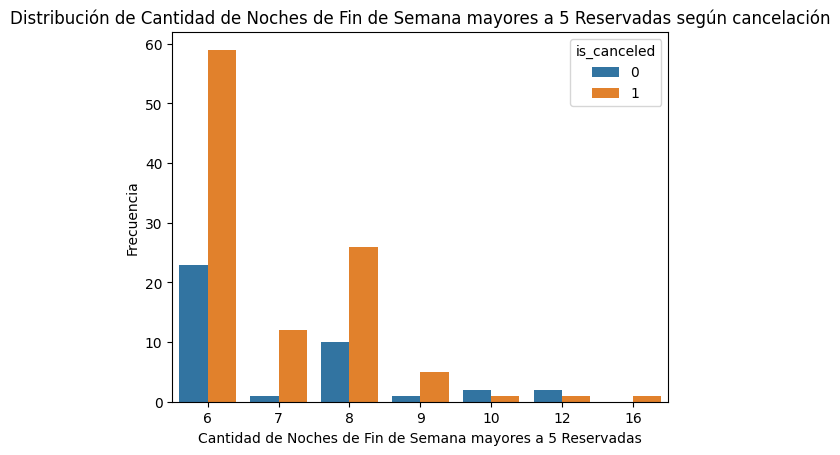

In [268]:
df = ds_trabajo.loc[ds_trabajo['stays_in_weekend_nights'] > 5]
grafico = sns.countplot(x=df['stays_in_weekend_nights'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de Noches de Fin de Semana mayores a 5 Reservadas')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de Noches de Fin de Semana mayores a 5 Reservadas según cancelación")

plt.show()

En cuanto a `stays_in_week_nights`, sucede algo similar a `stays_in_weekend_nights`. Tenemos algunos valores atípicos superiores.

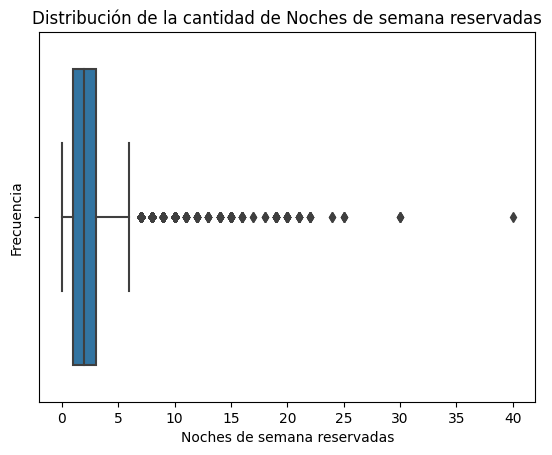

In [269]:
sns.boxplot(x=ds_trabajo["stays_in_week_nights"])
plt.xlabel('Noches de semana reservadas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de Noches de semana reservadas')
plt.show()

In [270]:
#Cuartiles
Q1_stays_in_week_nights=np.quantile(ds_trabajo.stays_in_week_nights,0.25)
Q3_stays_in_week_nights=np.quantile(ds_trabajo.stays_in_week_nights,0.75)

#Rango intercuartil
IQR_stays_in_week_nights=Q3_stays_in_week_nights-Q1_stays_in_week_nights

#Limite inferior Outliers
out_inf=Q1_stays_in_week_nights-1.5*IQR_stays_in_week_nights
out_sup=Q3_stays_in_week_nights+1.5*IQR_stays_in_week_nights
print(out_inf)
print(out_sup)

-2.0
6.0


In [271]:
outliers_inf = ds_trabajo[ds_trabajo['stays_in_week_nights'] < out_inf]
print("Outliers inferiores:", outliers_inf["stays_in_week_nights"].count())

outliers_sup = ds_trabajo[ds_trabajo['stays_in_week_nights'] > out_sup]
print("Outliers superiores:",outliers_sup["stays_in_week_nights"].count())

Outliers inferiores: 0
Outliers superiores: 1724


Si bien son pocos outliers superiores, creemos que hay una variabilidad respecto al target `is_canceled` para estos registros. Por otro lado, creemos que podemos obtener información haciendo un análisis multivariado de `stays_in_week_nights`, `stays_in_weekend_nights` (ambas están correlacionadas) y el target `is_canceled`. TODO

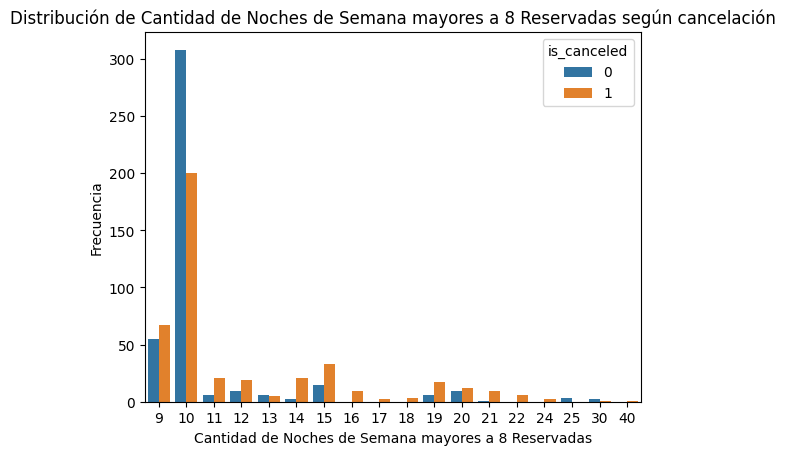

In [272]:
df = ds_trabajo.loc[ds_trabajo['stays_in_week_nights'] > 8]
grafico = sns.countplot(x=df['stays_in_week_nights'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de Noches de Semana mayores a 8 Reservadas')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de Noches de Semana mayores a 8 Reservadas según cancelación")

plt.show()

Para `previous_cancellations`, tenemos outliers superiores. En la notebook_1 habíamos analizado que la distribución de la variable respecto de `is_canceled` era muy variada, por lo tanto vamos a hacer un análisis más profundo de estos outliers para tomar una decisión.

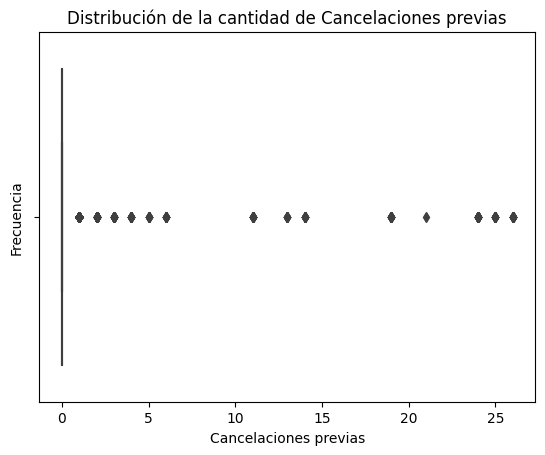

In [273]:
sns.boxplot(x=ds_trabajo["previous_cancellations"])
plt.xlabel('Cancelaciones previas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de Cancelaciones previas')
plt.show()

In [274]:
#Cuartiles
Q1_previous_cancellations=np.quantile(ds_trabajo.previous_cancellations,0.25)
Q3_previous_cancellations=np.quantile(ds_trabajo.previous_cancellations,0.75)

#Rango intercuartil
IQR_previous_cancellations=Q3_previous_cancellations-Q1_previous_cancellations

#Limite inferior Outliers
out_inf=Q1_previous_cancellations-1.5*IQR_previous_cancellations
out_sup=Q3_previous_cancellations+1.5*IQR_previous_cancellations
print(out_inf)
print(out_sup)

0.0
0.0


In [275]:
outliers_inf = ds_trabajo[ds_trabajo['previous_cancellations'] < out_inf]
print("Outliers inferiores:", outliers_inf["previous_cancellations"].count())

outliers_sup = ds_trabajo[ds_trabajo['previous_cancellations'] > out_sup]
print("Outliers superiores:",outliers_sup["previous_cancellations"].count())

Outliers inferiores: 0
Outliers superiores: 4394


Observamos esta variabilidad respecto de `is_canceled` separando las cantidades en dos barplots para mejorar la legibilidad. La cantidad de cancelaciones previas podría estar relacionada a la antelación con la cual se hace una reserva. Creemos que será útil hacer un análisis multivariado de `previous_cancellations`, `lead_time` y el target `is_canceled`. TODO

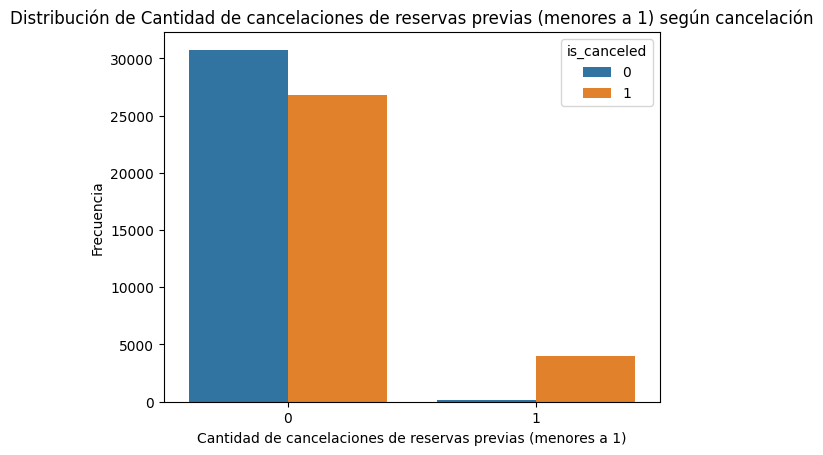

In [276]:
df = ds_trabajo.loc[ds_trabajo['previous_cancellations'] <= 1]
grafico = sns.countplot(x=df['previous_cancellations'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de cancelaciones de reservas previas (menores a 1)')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de cancelaciones de reservas previas (menores a 1) según cancelación")

plt.show()

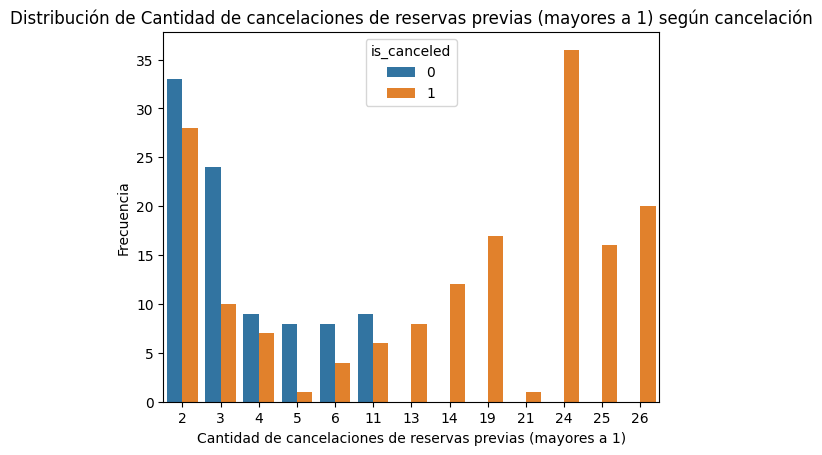

In [277]:
df = ds_trabajo.loc[ds_trabajo['previous_cancellations'] > 1]
grafico = sns.countplot(x=df['previous_cancellations'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de cancelaciones de reservas previas (mayores a 1)')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de cancelaciones de reservas previas (mayores a 1) según cancelación")

plt.show()

En cuanto a la variable `previous_bookings_not_canceled`, habíamos visto en la notebook_1 que tiene un comportamiento inverso a `previous_cancellations`: entre más reservas no canceladas, menor posibilidad de cancelación.

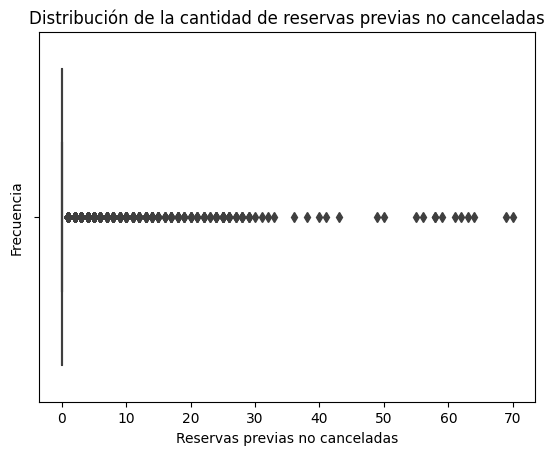

In [278]:
sns.boxplot(x=ds_trabajo["previous_bookings_not_canceled"])
plt.xlabel('Reservas previas no canceladas')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de reservas previas no canceladas')
plt.show()

In [279]:
#Cuartiles
Q1_previous_bookings_not_canceled=np.quantile(ds_trabajo.previous_bookings_not_canceled,0.25)
Q3_previous_bookings_not_canceled=np.quantile(ds_trabajo.previous_bookings_not_canceled,0.75)

#Rango intercuartil
IQR_previous_bookings_not_canceled=Q3_previous_bookings_not_canceled-Q1_previous_bookings_not_canceled

#Limite inferior Outliers
out_inf=Q1_previous_bookings_not_canceled-1.5*IQR_previous_bookings_not_canceled
out_sup=Q3_previous_bookings_not_canceled+1.5*IQR_previous_bookings_not_canceled
print(out_inf)
print(out_sup)

0.0
0.0


In [280]:
outliers_inf = ds_trabajo[ds_trabajo['previous_bookings_not_canceled'] < out_inf]
print("Outliers inferiores:", outliers_inf["previous_bookings_not_canceled"].count())

outliers_sup = ds_trabajo[ds_trabajo['previous_bookings_not_canceled'] > out_sup]
print("Outliers superiores:",outliers_sup["previous_bookings_not_canceled"].count())

Outliers inferiores: 0
Outliers superiores: 1538


Hay pocos outliers. TODO: sumarla al analisis multivariado anterior.

Para `booking_changes`, observamos una cantidad más considerable de outliers superiores.

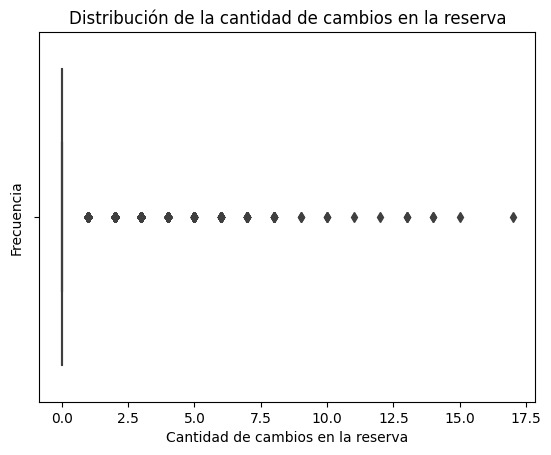

In [281]:
sns.boxplot(x=ds_trabajo["booking_changes"])
plt.xlabel('Cantidad de cambios en la reserva')
plt.ylabel('Frecuencia')
plt.title('Distribución de la cantidad de cambios en la reserva')
plt.show()

In [282]:
#z-score modificado
mediana_booking_changes=np.median(ds_trabajo.booking_changes)
MAD=np.median(np.absolute(ds_trabajo.booking_changes-mediana_booking_changes))

ds_trabajo['zm_booking_changes']=(ds_trabajo.booking_changes - mediana_booking_changes)*0.6745/MAD

zm_booking_changes_inf = ds_trabajo[ds_trabajo['zm_booking_changes'] < 3.5]
print("Cantidad de registros con z-score menor a 3.5:", zm_booking_changes_inf["zm_booking_changes"].count())

zm_booking_changes_sup = ds_trabajo[ds_trabajo['zm_booking_changes'] > 3.5]
print("Cantidad de registros con z-score mayor a 3.5:", zm_booking_changes_sup["zm_booking_changes"].count())

# eliminamos la columna zm
ds_trabajo = ds_trabajo.drop('zm_booking_changes', axis=1)

Cantidad de registros con z-score menor a 3.5: 0
Cantidad de registros con z-score mayor a 3.5: 8317


Sin embargo, notamos que en todos los casos se cancela menos de lo que no. Creemos que esta columna podría no estar aportando información. Vamos a hacer un análisis multivariado. TODO

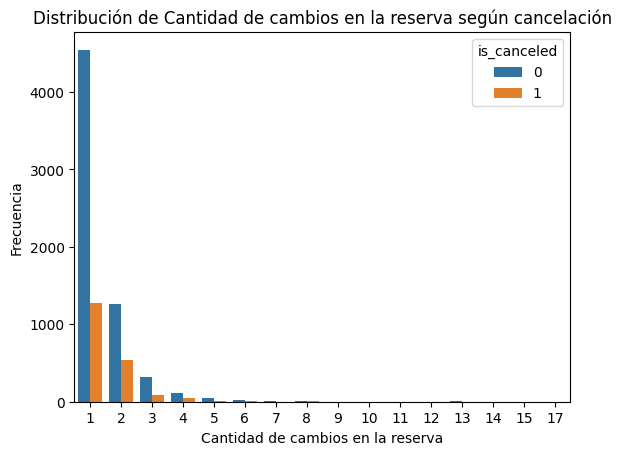

In [283]:
df = ds_trabajo.loc[ds_trabajo['booking_changes'] > 0]
grafico = sns.countplot(x=df['booking_changes'], hue='is_canceled', data=ds_trabajo)

plt.xlabel('Cantidad de cambios en la reserva')
plt.ylabel('Frecuencia')
plt.title("Distribución de Cantidad de cambios en la reserva según cancelación")

plt.show()

Para `adr`

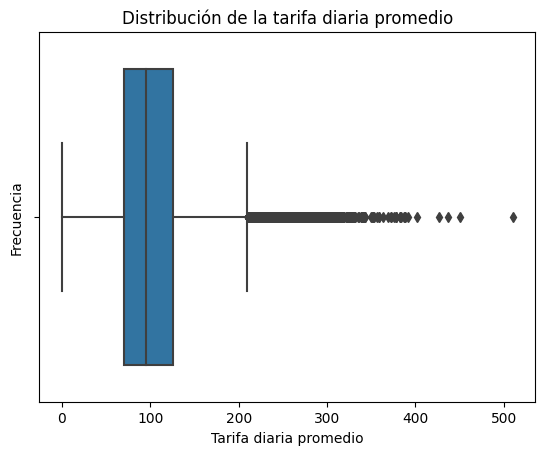

In [284]:
sns.boxplot(x=ds_trabajo["adr"])
plt.xlabel('Tarifa diaria promedio')
plt.ylabel('Frecuencia')
plt.title('Distribución de la tarifa diaria promedio')
plt.show()

In [285]:
#Cuartiles
Q1_adr =np.quantile(ds_trabajo.adr,0.25)
Q3_adr =np.quantile(ds_trabajo.adr,0.75)
IQR_adr=Q3_adr-Q1_adr
out_inf=Q1_adr-1.5*IQR_adr
out_sup=Q3_adr+1.5*IQR_adr
print(out_inf)
print(out_sup)
print(IQR_adr)
outliers_inf = ds_trabajo[ds_trabajo['adr'] < out_inf]
print("Outliers inferiores:", outliers_inf["adr"].count())
outliers_sup = ds_trabajo[ds_trabajo['adr'] > out_sup]
print("Outliers superiores:",outliers_sup["adr"].count())

-14.0
210.0
56.0
Outliers inferiores: 0
Outliers superiores: 2025


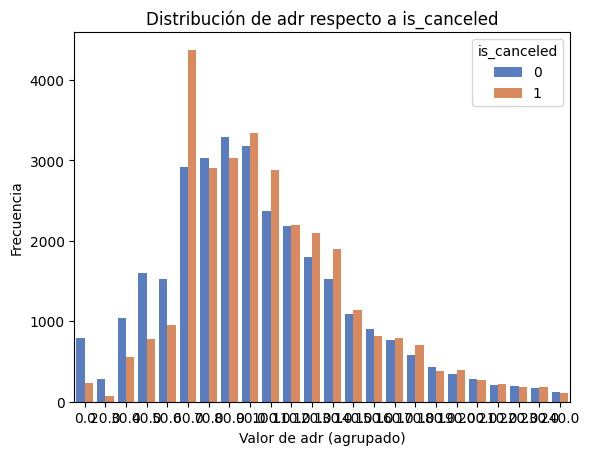

In [286]:

ds_trabajo['adr_group'] = (ds_trabajo['adr'] // 10) * 10
df = ds_trabajo.groupby('adr_group').filter(lambda x: len(x) > out_sup)
grafico = sns.countplot(x=df['adr_group'], hue='is_canceled', data=ds_trabajo, palette='muted')
plt.xlabel('Valor de adr (agrupado)')
plt.ylabel('Frecuencia')
plt.title("Distribución de adr respecto a is_canceled")
plt.show()

Podemos ver que apartir de los valores de adr con una media de 80 son muy aceptados, al haber poca taza de cancelados y que apartir de los mismos, el adr aumenta y su taza de cancelados se equipara."

Para `total_of_special_requests`

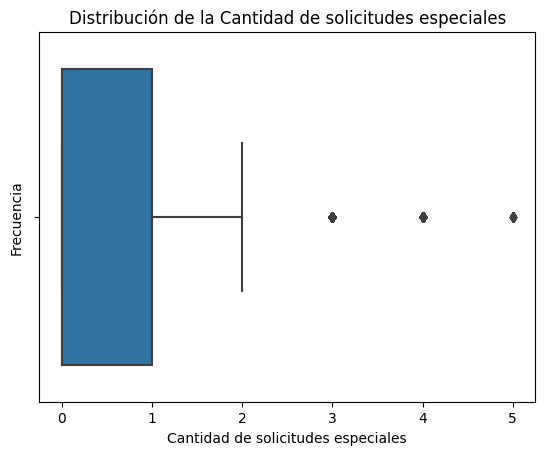

In [287]:
sns.boxplot(x=ds_trabajo["total_of_special_requests"])
plt.xlabel('Cantidad de solicitudes especiales')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Cantidad de solicitudes especiales')
plt.show()

In [288]:
#Cuartiles
Q1_total_of_special_requests =np.quantile(ds_trabajo.total_of_special_requests,0.25)
Q3_total_of_special_requests =np.quantile(ds_trabajo.total_of_special_requests,0.75)
IQR_total_of_special_requests=Q3_total_of_special_requests-Q1_total_of_special_requests
out_inf=Q1_total_of_special_requests-1.5*IQR_total_of_special_requests
out_sup=Q3_total_of_special_requests+1.5*IQR_total_of_special_requests
print(out_inf)
print(out_sup)
print(IQR_total_of_special_requests)
outliers_inf = ds_trabajo[ds_trabajo['total_of_special_requests'] < out_inf]
print("Outliers inferiores:", outliers_inf["total_of_special_requests"].count())
outliers_sup = ds_trabajo[ds_trabajo['total_of_special_requests'] > out_sup]
print("Outliers superiores:",outliers_sup["total_of_special_requests"].count())

-1.5
2.5
1.0
Outliers inferiores: 0
Outliers superiores: 1358


Para `total_guests`

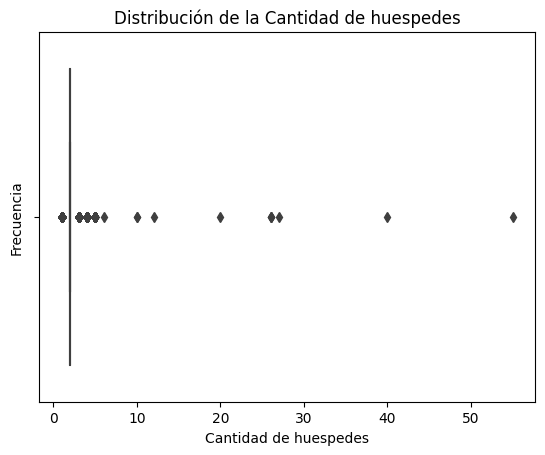

In [289]:
sns.boxplot(x=ds_trabajo["total_guests"])
plt.xlabel('Cantidad de huespedes')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Cantidad de huespedes')
plt.show()

In [290]:
#z-score modificado
mediana_total_guests=np.median(ds_trabajo.total_guests)
MAD=np.median(np.absolute(ds_trabajo.total_guests-mediana_total_guests))

ds_trabajo['zm_total_guests']=(ds_trabajo.total_guests - mediana_total_guests)*0.6745/MAD

zm_total_guests_inf = ds_trabajo[ds_trabajo['zm_total_guests'] < 3.5]
print("Cantidad de registros con z-score menor a 3.5:", zm_total_guests_inf["zm_total_guests"].count())

zm_total_guests = ds_trabajo[ds_trabajo['zm_total_guests'] > 3.5]
print("Cantidad de registros con z-score mayor a 3.5:", zm_total_guests["zm_total_guests"].count())

ds_trabajo = ds_trabajo.drop('zm_total_guests', axis=1)

Cantidad de registros con z-score menor a 3.5: 11411
Cantidad de registros con z-score mayor a 3.5: 7442


Para `market_segment`

Online TA        29269
Offline TA/TO    12384
Groups           11545
Direct            5757
Corporate         2484
Complementary      359
Aviation           113
Undefined            2
Name: market_segment, dtype: int64


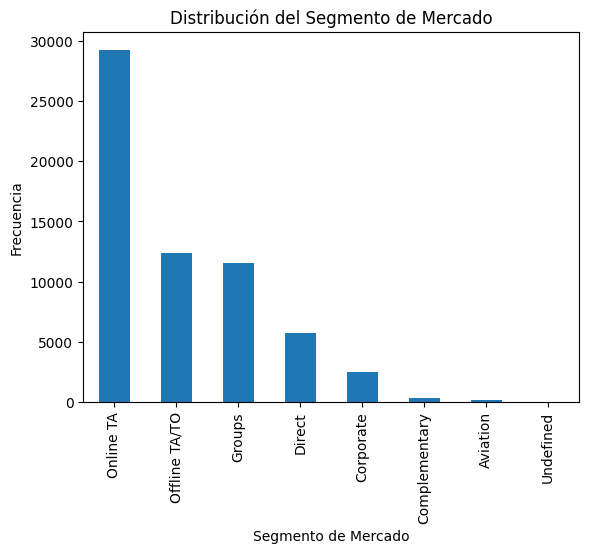

In [291]:
frecuencia = ds_trabajo['market_segment'].value_counts()
print(frecuencia)
plt.xlabel('Segmento de Mercado')
plt.ylabel('Frecuencia')
plt.title('Distribución del Segmento de Mercado')
frecuencia.plot(kind='bar')
plt.show()

Para `distribution_channel`

TA/TO        51849
Direct        6799
Corporate     3172
GDS             89
Undefined        4
Name: distribution_channel, dtype: int64


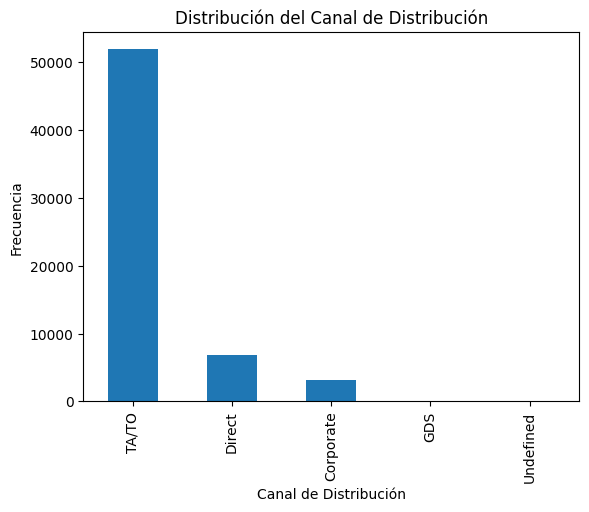

In [292]:
frecuencia = ds_trabajo['distribution_channel'].value_counts()
print(frecuencia)

plt.xlabel('Canal de Distribución')
plt.ylabel('Frecuencia')
plt.title('Distribución del Canal de Distribución')
frecuencia.plot(kind='bar')
plt.show()

Para `deposit_type`

No Deposit    51763
Non Refund    10150
Name: deposit_type, dtype: int64


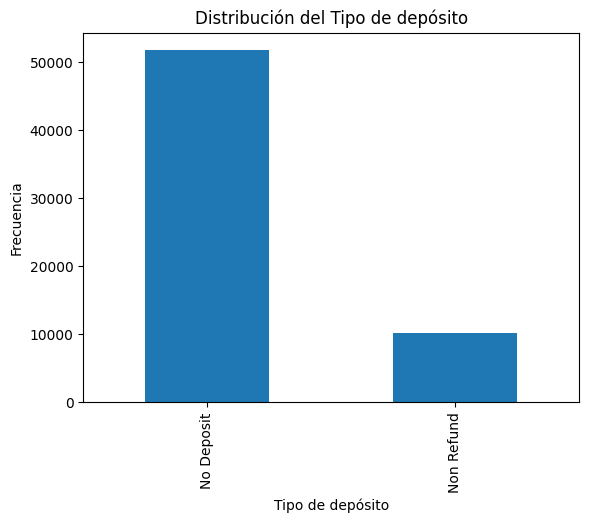

In [293]:
frecuencia = ds_trabajo['deposit_type'].value_counts()
print(frecuencia)

plt.xlabel('Tipo de depósito')
plt.ylabel('Frecuencia')
plt.title('Distribución del Tipo de depósito')
frecuencia.plot(kind='bar')
plt.show()

Para `customer_type`

Transient          47449
Transient-Party    12168
Contract            2296
Name: customer_type, dtype: int64


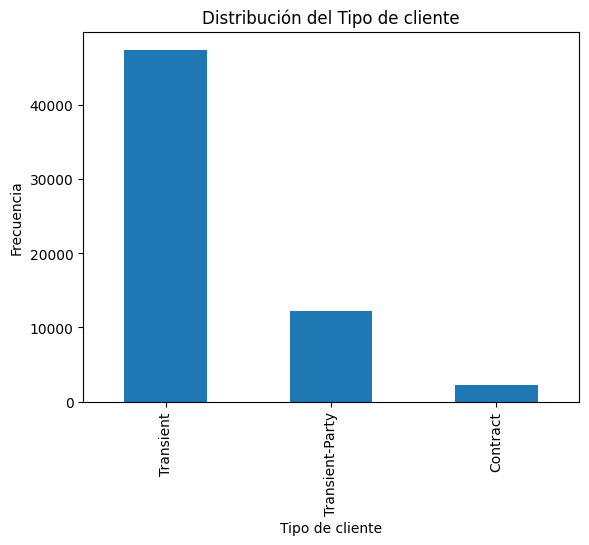

In [294]:
frecuencia = ds_trabajo['customer_type'].value_counts()
print(frecuencia)

plt.xlabel('Tipo de cliente')
plt.ylabel('Frecuencia')
plt.title('Distribución del Tipo de cliente')
frecuencia.plot(kind='bar')
plt.show()

In [295]:
ds_trabajo.duplicated().sum()

0

In [296]:
ds_trabajo.reservation_status_date

0        2016-08-25
1        2015-11-01
2        2016-10-14
3        2016-11-29
4        2017-03-26
            ...    
61908    2017-01-23
61909    2016-09-03
61910    2017-05-11
61911    2015-07-08
61912    2016-04-09
Name: reservation_status_date, Length: 61913, dtype: object

In [297]:
ds_trabajo = ds_trabajo.drop(ds_trabajo[ds_trabajo['distribution_channel'] == 'Undefined'].index)
ds_trabajo = ds_trabajo.drop(ds_trabajo[ds_trabajo['market_segment'] == 'Undefined'].index)

In [298]:
ds_trabajo['reservation_status_date'] = pd.to_datetime(ds_trabajo.reservation_status_date)
ds_trabajo.reservation_status_date = ds_trabajo.reservation_status_date.apply(lambda x: x.timestamp())
ds_trabajo['arrival_date'] = pd.to_datetime(ds_trabajo.arrival_date)
ds_trabajo.arrival_date = ds_trabajo.arrival_date.apply(lambda x: x.timestamp())



In [299]:
ds_trabajo = ds_trabajo.drop("reservation_status_date",axis=1)
ds_trabajo = ds_trabajo.drop("adr_group",axis=1)
ds_trabajo = ds_trabajo.drop("id",axis=1)

Separamos el dataset de entrenamiento usando una proporción de 70%-30% y estratificando las columnas.

In [306]:
#Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x=ds_trabajo.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_trabajo_y = ds_trabajo['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

Vemos las proporciones de cancelado / no cancelado para revisar que estas categorías esten bien distirbuidas.

In [307]:
num_cancelados = sum(y_train)
num_no_cancelados = len(y_train) - num_cancelados
prop_cancelados = num_cancelados / len(y_train)

print("Número de cancelaciones:", num_cancelados)
print("Número de no cancelaciones:", num_no_cancelados)
print("Proporción de cancelaciones:", prop_cancelados)


Número de cancelaciones: 21559
Número de no cancelaciones: 21777
Proporción de cancelaciones: 0.49748477016798964


Vamos a realizar one hot enconding en las columnas categóricas para poder entrenar nuestro modelo.

In [308]:
# One hot encoding para variables categoricas
ds_trabajo = pd.get_dummies(ds_trabajo, columns=['hotel',
                                                 'market_segment',
                                                 'distribution_channel',
                                                 'is_repeated_guest',
                                                 'deposit_type',
                                                 'customer_type',
                                                 'agent_specified',
                                                 'more_than_zero_days_in_waiting_list',
                                                 'season',
                                                 'region',
                                                 'room_type_match'], drop_first=True)
ds_trabajo.head()


KeyError: "None of [Index(['hotel', 'market_segment', 'distribution_channel', 'is_repeated_guest',\n       'deposit_type', 'customer_type', 'agent_specified',\n       'more_than_zero_days_in_waiting_list', 'season', 'region',\n       'room_type_match'],\n      dtype='object')] are in the [columns]"

Vamos a hacer un primer árbol de decisión simple, especificando una profundidad de 20, con criterio de entropía y con 10 como mínimo número de muestras por hoja.

In [309]:
#Creamos un clasificador con hiperparámetros 
tree_model = tree.DecisionTreeClassifier(criterion="entropy",
                                         max_depth = 20, 
                                         min_samples_leaf=10,
                                         random_state=2) 
#Entrenamos el modelo
model = tree_model.fit(X = x_train, y = y_train)

Realizamos una primera predicción sobre el set de test con este árbol.

In [310]:
y_pred = model.predict(x_test)
#Valores Predichos
y_pred

array([0, 1, 0, ..., 1, 1, 0], dtype=int64)

Visualizamos su matriz de confusión.

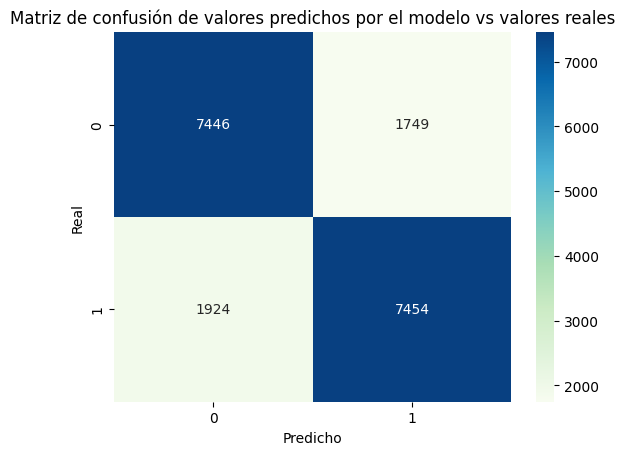

In [311]:
tabla=confusion_matrix(y_test, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.title("Matriz de confusión de valores predichos por el modelo vs valores reales")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

Vamos a analizar sus métricas.

In [312]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.802239810477575
Recall: 0.7948389848581787
Precision: 0.8099532761056177
f1 score: 0.8023249555998062


Podemos ver que el modelo tiene una precisión del 80.99% y un recall de 79.4% aproximadamente. Esto nos indica que nuestro modelo tiene una precisión relativamente buena, lo que implica que nuestro modelo es bueno para predecir cuando una reserva no será cancelada. Nos gustaría ahora mejorar su recall, ya que creemos que podemos mejorar su precisión sobre si una reserva será efectivamente cancelada. Vamos a buscar mejorar el recall de tal manera que mejore el f1 score, al estar más equilibrado respecto a la precisión.

Vamos a buscar hiperparámetros por medio de Grid Search. Vamos a usar profundidades de 10, 20 y 30 y una cantidad mínima de muestras por hoja de 5, 10 y 15. Probaremos esto con 5 folds y con el criterio de Gini.

In [313]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
params = {'max_depth': [10, 20, 30],
          'min_samples_leaf': [5, 10, 15]}
tree_model = DecisionTreeClassifier(criterion="gini")
grid_search = GridSearchCV(estimator=tree_model, 
                           param_grid=params, 
                           scoring='accuracy', 
                           cv=5)
grid_search.fit(X=x_train, y=y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best parameters: {'max_depth': 30, 'min_samples_leaf': 15}
Best cross-validation score: 0.8110886023960425


In [314]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Obtener el mejor modelo ajustado por GridSearchCV
best_tree_model = grid_search.best_estimator_

# Realizar predicciones sobre los datos de prueba
y_pred = best_tree_model.predict(x_test)

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("f1 score:", f1)


Accuracy: 0.8003015129489043
Recall: 0.7696737044145874
Precision: 0.823314702863009
f1 score: 0.7955910719206393


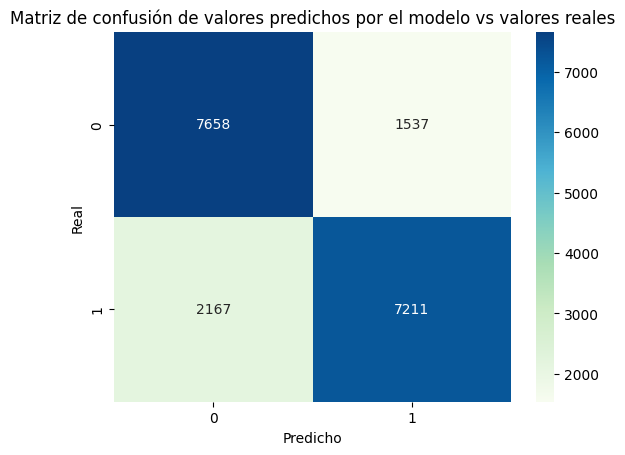

In [ ]:
tabla=confusion_matrix(y_test, y_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.title("Matriz de confusión de valores predichos por el modelo vs valores reales")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()